In [1]:
# Import Modules
import os
import warnings
warnings.simplefilter("ignore", UserWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal as ss
import numpy as np

In [2]:
# Directories and files

# Data Directories
DATA_DIR = "../../data/kosdaq/combined/"  # Using kosdaq data

In [3]:
# Load Data File List
file_list = os.listdir(DATA_DIR)
codes_list = [f[:-4] for f in file_list]

In [4]:
codes_list[:5]

['000250', '000440', '001000', '001540', '001810']

## 1. Calculate Pearson Correlation

In [5]:
# Calculate Correlation Data

correlation_list = []

for file in file_list:
    # Load File
    filepath= DATA_DIR + file
    df = pd.read_csv(filepath, index_col=0)
    
    if df.empty:
        print(file)
        continue
        
    # Scale
    df -= df.min()
    df /= df.max()
    
    # Calculate Pearson Correlation
    correlation_value = df.corr().iloc[0,2]
    correlation_list.append(correlation_value)

158430.csv
234690.csv
330990.csv
331380.csv


In [6]:
# Convert To Dataframe
pearson_df = pd.DataFrame(list(zip(codes_list,correlation_list)), columns=['code','corr'])
pearson_df = pearson_df.dropna()

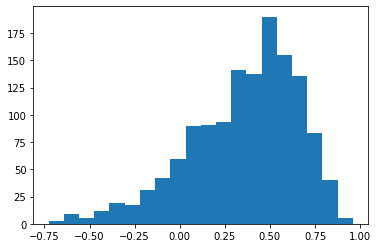

In [7]:
# Draw Histogram
plt.hist(pearson_df['corr'], 20)
plt.show()

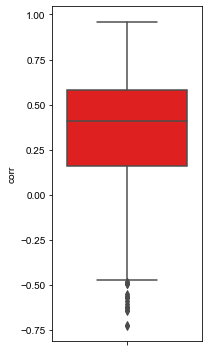

In [16]:
# Draw Boxplot
plt.subplots(1,1,figsize=(3,5))
sns.set_style('whitegrid')
sns.boxplot(pearson_df['corr'],color='red',orient='v')
plt.tight_layout()

In [17]:
# See Outliers
positive_outliers = pearson_df[pearson_df['corr'] > 0.4]
print(positive_outliers.head())
negative_outliers = pearson_df[pearson_df['corr'] < -0.4]
print(negative_outliers.head())

     code      corr
0  000250  0.642033
1  000440  0.494042
2  001000  0.496340
4  001810  0.552963
5  001840  0.719365
       code      corr
12   003380 -0.463508
41   008800 -0.620975
102  019570 -0.644902
125  023890 -0.482969
174  031980 -0.495963


## 2. Normalized Cross Correlation With Time Shift

In [18]:
# Function to calculate normalized cross correlation
def ccf(x, y, lag_max = 100):
    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]

In [20]:
ncc_list = []
lag_list = []
lag = 10

for file in file_list:
    # Load File
    filepath= DATA_DIR + file
    df = pd.read_csv(filepath, index_col=0)
    
    if df.empty:
        print(file)
        continue
    
    # Scale
    df -= df.min()
    df /= df.max()

    # Calculate Normalized Cross Correlation With Different Time Shift(Lag=10)
    ncc = ccf(df['price'].values, df['ratio'].values, lag_max=lag)
    
    # Find index of max absolute correlation
    max_idx = np.argmax(abs(ncc))
    
    # Find value of max absolute correlation
    max_ncc = ncc[max_idx]
    
    # Find lag for max value
    max_lag = max_idx - lag
    
    # print(file, max_ncc, max_lag)
    ncc_list.append(max_ncc)
    lag_list.append(max_lag)

158430.csv
234690.csv
330990.csv
331380.csv


In [21]:
# Convert To Dataframe
ncc_df = pd.DataFrame(list(zip(codes_list,ncc_list,lag_list)), columns=['code','ncc', 'lag'])
ncc_df = ncc_df.dropna()

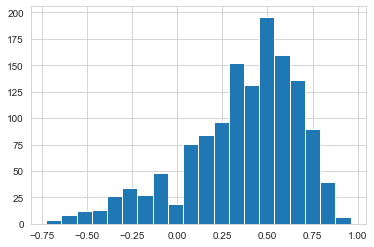

In [22]:
# Draw Histogram
plt.hist(ncc_df['ncc'], 20)
plt.show()

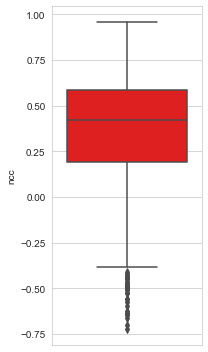

In [23]:
# Draw Boxplot
plt.subplots(1,1, figsize=(3,5))
sns.set_style('whitegrid')
sns.boxplot(ncc_df['ncc'],color='red',orient='v')
plt.tight_layout()

In [24]:
# See Outliers
positive_outliers = ncc_df[ncc_df['ncc'] > 0.4]
print(positive_outliers.head())
negative_outliers = ncc_df[ncc_df['ncc'] < -0.4]
print(negative_outliers.head())

     code       ncc  lag
0  000250  0.658900  -10
1  000440  0.494042    0
2  001000  0.496340    0
4  001810  0.552963    0
5  001840  0.719365    0
       code       ncc  lag
12   003380 -0.495944    4
41   008800 -0.636183   10
102  019570 -0.644902    0
125  023890 -0.482969    0
174  031980 -0.507735   -4


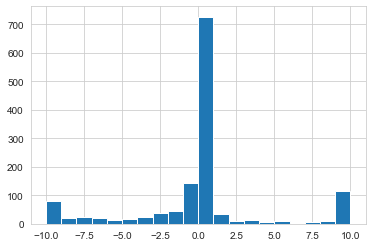

In [25]:
plt.hist(ncc_df['lag'], 20)
plt.show()

## 3. Normalized Cross Correlation With Time Shift (Using Percentage Changes)

In [32]:
ncc_pct_list = []
lag_pct_list = []
lag = 10

for file in file_list:
    # Load File
    filepath= DATA_DIR + file
    df = pd.read_csv(filepath, index_col=0)
    
    if df.empty:
        print(file)
        continue
    
    df = df.pct_change()
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    df = df.abs()

    # Calculate Normalized Cross Correlation With Different Time Shift(Lag=10)
    try:
        ncc = ccf(df['price'].values, df['ratio'].values,lag_max=lag)
    except ValueError:
        continue
        
    # Find max index
    max_idx = np.argmax(abs(ncc))
    # Find max correlation
    max_ncc = ncc[max_idx]
    # Find max lag
    max_lag = max_idx - lag
    
    # print(file, max_ncc, max_lag)
    ncc_pct_list.append(max_ncc)
    lag_pct_list.append(max_lag)

158430.csv
234690.csv
330990.csv
331380.csv


In [33]:
# Convert To Dataframe
pct_df = pd.DataFrame(list(zip(codes_list,ncc_pct_list,lag_pct_list)), columns=['code','ncc', 'lag'])
pct_df = pct_df.dropna()

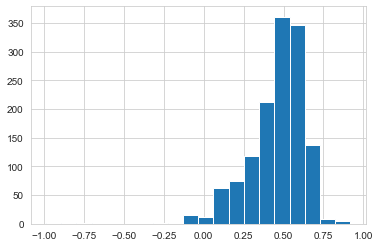

In [34]:
# Draw Histogram
plt.hist(pct_df['ncc'], 20)
plt.show()

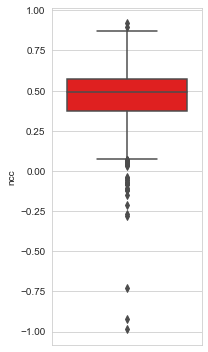

In [35]:
# Draw Boxplot
plt.subplots(1,1, figsize=(3,5))
sns.set_style('whitegrid')
sns.boxplot(pct_df['ncc'],color='red',orient='v')
plt.tight_layout()

In [36]:
# See Outliers
# print(df['corr'])
positive_outliers = pct_df[pct_df['ncc'] > 0.4]
print(positive_outliers.head())
negative_outliers = pct_df[pct_df['ncc'] < -0.4]
print(negative_outliers.head())

     code       ncc  lag
0  000250  0.601822    0
1  000440  0.501978    0
2  001000  0.602056    0
5  001840  0.547136    0
7  002290  0.469234    0
        code       ncc  lag
649   078890 -0.986932   -8
1197  242040 -0.920230   -8
1329  318000 -0.727324  -10
